In [2]:

from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

import tensorflow as tf
from mat4py import loadmat
import numpy as np
import pandas as pd
from Utilities.plotting_sine import plot_sine
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.L2_error_computation import error_L2
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.model_constraint import compute_interior_loss
from Utilities.model_constraint_weak import compute_interior_loss_weak
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 7# For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  =100
    activation        = 'relu'
    classification_act= 'linear'
    model_constraint  =  1
    regularization    = 0.0
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 40000
    
    num_networks      = 6
    
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 20
    activation        = 'relu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    model_constraint  =  300
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 2000
    
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234

        
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################




Text(0, 0.5, 'Accuracy')

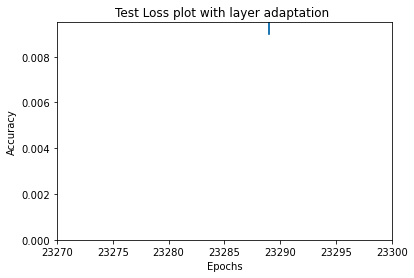

In [55]:
 import matplotlib.pyplot as plt
    
trainable=2
    #=== Hyperparameters and Run Options ===#    
hyperp = Hyperparameters()
hyperp_new=Hyperparameters_new()
run_options = RunOptions()
    

    #=== File Names ===#
file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
data_train, labels_train,\
data_test, labels_test,\
data_input_shape, num_channels, label_dimensions\
= load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
gauss_solution=np.loadtxt("gauss_solution.data")
gauss_solution = tf.cast(gauss_solution,tf.float32)
    
gauss_points = loadmat('gauss_points.mat')
gauss_points=np.array(list(gauss_points.values()))[-1]
gauss_points = tf.cast(gauss_points,tf.float32)
    
gauss_points_new = loadmat('gauss_points_new.mat')
gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    
gauss_weights = loadmat('gauss_weights.mat')
gauss_weights=np.array(list(gauss_weights.values()))[-1].squeeze(-1)
    
gauss_weights_new = loadmat('gauss_weights_new.mat')
gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

    
Coordinates = loadmat('Coordinates.mat')
Coordinates=np.array(list(Coordinates.values()))[-1]
Coordinates = tf.cast(Coordinates,tf.float32)
    
    
Stiffness = loadmat('Stiffness.mat')
Stiffness=np.array(list(Stiffness.values()))[-1]
Stiffness = tf.cast(Stiffness,tf.float32)
    
load = loadmat('observation.mat')
load=np.array(list(load.values()))[-1]
load=tf.cast(load,tf.float32)
load=tf.reshape(load,(len(load),1))
    
Solution = loadmat('Solution.mat')
Solution=np.array(list(Solution.values()))[-1]
Solution=tf.cast(Solution,tf.float32)
Solution=tf.reshape(Solution,(len(Solution),1))
    
    
storage_accuracy_array=[]
    
no_epoch=hyperp.num_epochs
    
for i in range(2,3):
    
    trainable_hidden_layer_index=i
    
    
    name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


    df_metrics =pd.read_csv(name)

    array_metrics = df_metrics.to_numpy()

        
 
    storage_accuracy_array=np.concatenate((storage_accuracy_array, array_metrics[:,1]), axis=0)
    
fig_accuracy = plt.figure()
x_axis = np.linspace(1, len(storage_accuracy_array), len(storage_accuracy_array), endpoint = True)
plt.plot(x_axis, storage_accuracy_array)
plt.ylim(0, 0.0095)
plt.xlim(23270,23300)
#plt.title('Accuracy for: ' + run_options.filename)
plt.title('Test Loss plot with layer adaptation ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


In [9]:
array_metrics[:,1]

NameError: name 'array_metrics' is not defined